### Libraries & Packages

In [3]:
# data processessing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## NN packages
import tensorflow as tf
from tensorflow import keras

# NLP packages
!pip install -q transformers
!pip install pydot
from transformers import BertTokenizer,TFAutoModel, TFBertModel, BertForSequenceClassification




### Importing/Preprocessing data

In [4]:
train_data = pd.read_csv('./clean_train_data.csv')
test_data = pd.read_csv('./clean_test_data.csv')

In [ ]:
train_data

In [5]:
# creating train/val datasets
x_train, x_val, y_train, y_val = train_test_split(train_data.text, train_data.label, test_size=0.20, random_state=42)
# creating test datasets
x_test = test_data.text
y_test = test_data.label

In [6]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}\n")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (13592,)
y_train shape: (13592,)

x_val shape: (3398,)
y_val shape: (3398,)

x_test shape: (4117,)
y_test shape: (4117,)


### Gloabl Variables

In [ ]:
max_length = 350    #max tweet length = 320

### Utility functions

In [13]:
# Function for creating tokenized data and outputs for models

def create_datasets(tokenizer, train=x_train, val=x_val, test=x_test, max_length=350):
  # Variables
  # train/val/test = datasets to encode
  # tokenizer = bert tokenizer


  # tokenize the dataset, truncate when passed `max_length`,
  # and pad with 0's when less than `max_length` and return a tf Tensor
  # train_encodings = bert_tokenizer(list(train), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  # valid_encodings = bert_tokenizer(list(val), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  # test_encodings = bert_tokenizer(list(test), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

  train_encodings = tokenizer(list(train), truncation=True, padding=True, return_tensors='tf')
  valid_encodings = tokenizer(list(val), truncation=True, padding=True, return_tensors='tf')
  test_encodings = tokenizer(list(test), truncation=True, padding=True, return_tensors='tf')

  return train_encodings, valid_encodings, test_encodings


In [8]:
 # Function for creating model
def create_bert_multiclass_model(model,
                                 num_classes = 20,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 activation='softmax'):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """

    bert_model = model

    # building bert inputs
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # building bert model
    bert_out = bert_model(bert_inputs)
    pooler_output = bert_out[1] # bert_out.pooler_output

    # building hidden layers
    last_hidden_output = tf.keras.layers.Dense(hidden_size, activation='relu', name='last_hidden_output')(pooler_output)
    last_hidden_output = tf.keras.layers.Dropout(dropout, name='dropout')(last_hidden_output)
    bert_cls_prediction = keras.layers.Dense(num_classes, activation=activation, name='cls_output')(last_hidden_output)

    # compiling model
    bert_cls_model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=bert_cls_prediction)
    bert_cls_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics='accuracy')

    ### END YOUR CODE
    return bert_cls_model

In [9]:
# Function to show model parameters/shape
def depict_model(model):

  display(model.summary())
  display(keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

### BERT-base model

In [ ]:
# Loading bert-base-uncased tokenizer/model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Creating base-base-uncased encodings
train_encodings, valid_encodings, test_encodings = create_datasets(bert_tokenizer)

In [ ]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
# Creating bert-base-uncased model
bert_base_model = create_bert_multiclass_model(bert_model)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                            

None

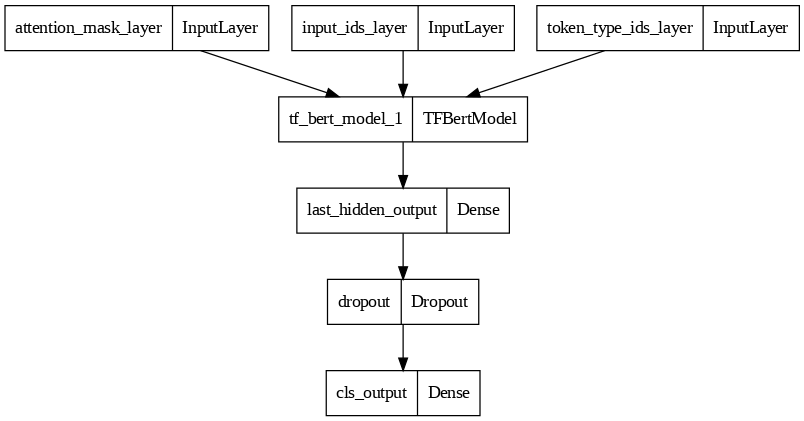

In [ ]:
# Viewing model
depict_model(bert_base_model)

In [20]:
# Running bert-base model
bertbase_model_history = bert_base_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=1)

NameError: ignored

### Fin-BERT Model

In [11]:
# Loading finbert tokenizer/model
finbert = TFAutoModel.from_pretrained('yiyanghkust/finbert-esg', num_labels=20, ignore_mismatched_sizes=True, from_pt=True)
finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg', num_labels=20)

# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain')
# finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

# FinBERT-FinVocab-Uncased (Recommended)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
# Creating base-base-uncased encodings
finbert_train_encodings, finbert_valid_encodings, finbert_test_encodings = create_datasets(finbert_tokenizer)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [15]:
finbert_train_encodings

{'input_ids': <tf.Tensor: shape=(13592, 137), dtype=int32, numpy=
array([[    3,    90,   230, ...,     0,     0,     0],
       [    3,  1828,  2508, ...,     0,     0,     0],
       [    3,   160,  2455, ...,     0,     0,     0],
       ...,
       [    3,  4807,  6569, ...,     0,     0,     0],
       [    3, 12149, 19309, ...,     0,     0,     0],
       [    3, 23912, 16807, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(13592, 137), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(13592, 137), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [16]:
type(finbert_train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [17]:
# Creating finbert model
finbert_model = create_bert_multiclass_model(finbert)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                              

None

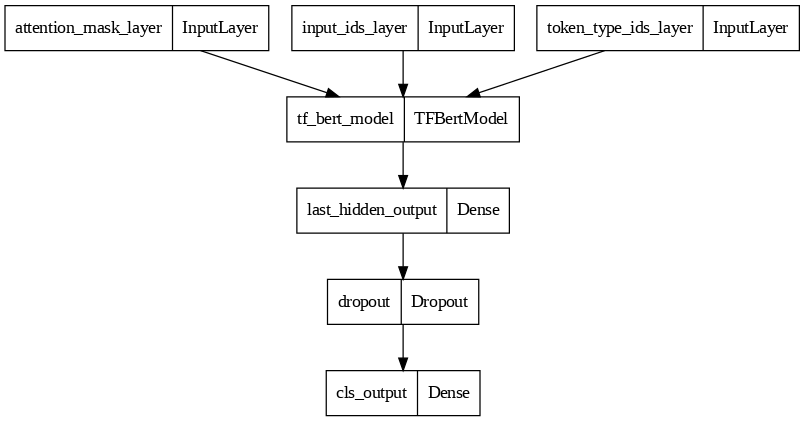

In [18]:
depict_model(finbert_model)

In [ ]:
finbert_model_history = finbert_model.fit([finbert_train_encodings.input_ids, finbert_train_encodings.token_type_ids, finbert_train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([finbert_valid_encodings.input_ids, finbert_valid_encodings.token_type_ids, finbert_valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=1)


  35/1699 [..............................] - ETA: 6:35:22 - loss: 2.6655 - accuracy: 0.2321